In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from shared import read_dataset, plot_results

2023-11-05 10:48:00.755819: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 10:48:00.785882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 10:48:00.785911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 10:48:00.785928: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 10:48:00.790682: I tensorflow/core/platform/cpu_feature_g

In [2]:
start = "2010-01-01"
end = "2020-01-01"
target_column_name = 'Adj Close'
model_path = '../models/lstm_model/price_generator.h5'

GS = read_dataset('../data/GS.csv', start, end)

GS['Close_Diff'] = GS['Close'].diff()
GS.dropna(inplace=True) # initially NAN for moving averages

cols = [target_column_name] + [ col for col in GS if col != target_column_name]
target_column = list(GS.columns).index(target_column_name)
data = GS[cols]

In [3]:
# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

# Split the data
train_size = int(len(data_array) * 0.70)
evaluation_size = int(len(data_array) * 0.0) # no evaluation

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i])
    return np.array(sequence_data), np.array(sequence_target)

SEQUENCE_LENGTH = 17
data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

train_data, eval_data, test_data = data_sequences[:train_size], data_sequences[train_size:train_size+evaluation_size], data_sequences[train_size+evaluation_size:]
train_target, eval_target, test_target = target_sequences[:train_size], target_sequences[train_size:train_size+evaluation_size], target_sequences[train_size+evaluation_size:]

In [ ]:
# TESTING CORRECTNESS OF GENERATED SEQUENCES
test_index = -1
a = scaler_data.inverse_transform(data_sequences[test_index])
b = scaler_target.inverse_transform(target_sequences)

for i in range (0, 17):
    print(f"A[{i}]: {a[i][0]}")

print(f'b: {b[test_index]}')

In [4]:
def build_model():
    """LSTM model"""
    model = keras.Sequential()
    model.add(keras.layers.LSTM(256, input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(keras.layers.Dense(1))
    return model

def train_model(model, train_data, train_target, eval_data, eval_target, epochs=30, batch_size=256):
    model.compile(optimizer='adam', loss='mean_squared_error')
    if (eval)
    model.fit(train_data, train_target, epochs=epochs, batch_size=batch_size, verbose=2)


In [7]:
epochs = 1000
batch_size = 256

## GENERATE MODEL ##
model = build_model()
train_model(model, train_data, train_target, epochs, batch_size)
# model.save(model_path)

## LOAD MODEL ##
# model = load_model(model_path)

2023-11-05 10:42:39.164967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 10:42:39.197744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 10:42:39.197906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-05 10:42:42.276042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905


23/23 [==============================] - 0s 2ms/step


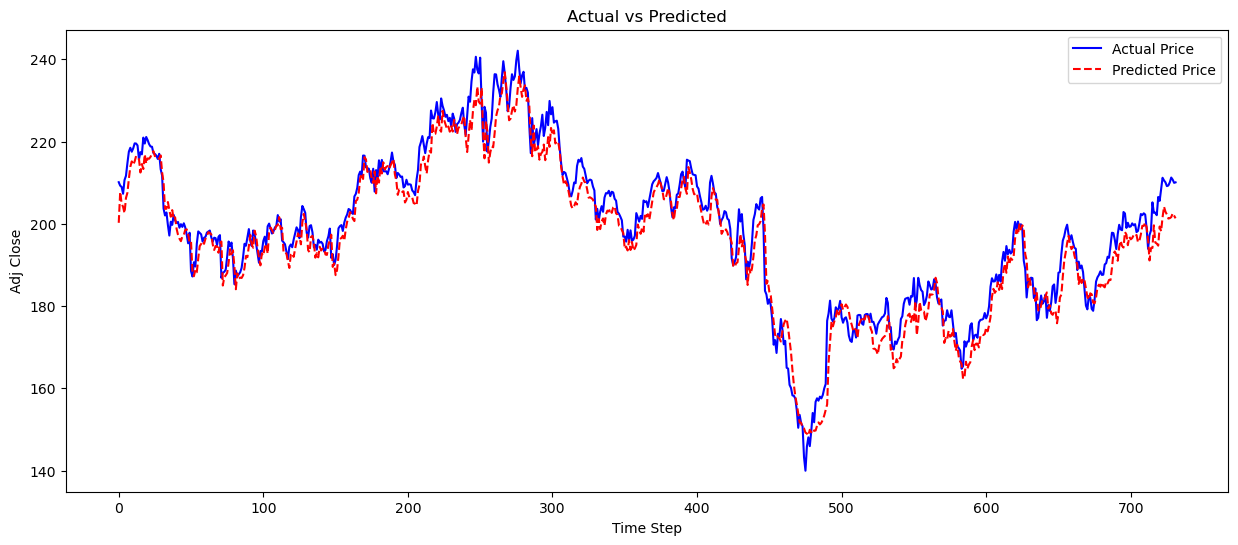

In [8]:
# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(model.predict(test_data))
price_actual_array = scaler_target.inverse_transform(test_target.reshape(-1, 1)).flatten()

## PLOTting ##
plot_results(price_actual_array, price_predicted_array, target_column_name)